In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import subprocess
import pandas as pd
import numpy as np

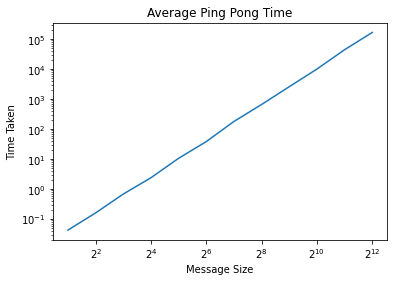

In [10]:
header = ['Processors', 'Message Size', 'Time Taken']
data = pd.read_csv('example.csv', header=0)
data.columns = header
data.head()

processors = data['Processors']
messageSize = data['Message Size']
time = data['Time Taken']
iterations = 100

avgCommunicationTime = time / iterations

plt.figure()
plt.plot(messageSize, avgCommunicationTime)
plt.xscale('log', base=2)
plt.yscale('log')
plt.title('Average Ping Pong Time')
plt.xlabel('Message Size')
plt.ylabel('Time Taken')
plt.show()